Stein VI ideally combines scalability of variational inference with flexibility of non parametric posterior densities.  A good test case is one with a multi-modal posterior. 

In [1]:
%pylab inline

import numpy as np
import numpyro
import jax
import jax.numpy as jnp
import nfjax
numpyro.set_host_device_count(8)
import arviz as az

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
** shtns is not available


## Curve fitting Jansen Rit

Let's take a look at the Jansen Rit model, just to do some curve fitting.

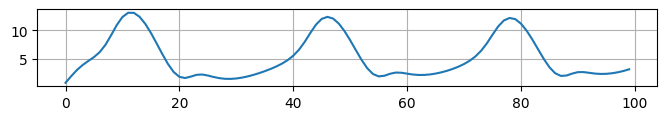

In [2]:
def make_curve():
    dt = 5
    ts = np.r_[:100]
    _, loop = nfjax.make_ode(dt, lambda x, p: nfjax.jr_dfun(x, 0, p))
    def curve(x0,p):
        xs = loop(x0, ts, p)
        v = xs[:, 1] - xs[:, 2]
        return v
    return curve

curve = make_curve()
x0 = np.zeros(6)
p = nfjax.jr_default_theta
x = curve(x0, p)
figure(figsize=(8, 1)); plot(x); grid(1)

## MCMC initial conditions only

We can then write out detailed Bayesian model with priors, such that we infer the initial conditions of the curve generated:

In [4]:
def model(x=None):
    from numpyro import sample
    from numpyro.distributions import Normal as N
    x0h = sample('x0h', N(np.zeros(6), 1))
    xh_mu = curve(x0h, p)
    sample('xh', N(xh_mu, 1), obs=x)

Let's run that with several MCMC chains,

In [14]:
nuts_kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_warmup=500, num_samples=500)
key = jax.random.PRNGKey(0)
mcmc.run(key, x=x)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [15]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0h[0],-0.492,0.295,-1.005,0.014,0.017,0.012,271.0,295.0,1.02
x0h[1],-0.090,0.925,-1.902,1.528,0.037,0.027,625.0,690.0,1.01
x0h[2],0.083,0.952,-1.610,1.978,0.046,0.032,447.0,410.0,1.01
x0h[3],0.068,0.041,-0.001,0.143,0.002,0.002,287.0,330.0,1.02
x0h[4],0.354,0.348,-0.268,1.041,0.015,0.011,506.0,492.0,1.01
x0h[5],0.143,0.095,-0.035,0.309,0.006,0.004,272.0,208.0,1.01


$\hat{R}$ looks ok, as do pair plots:

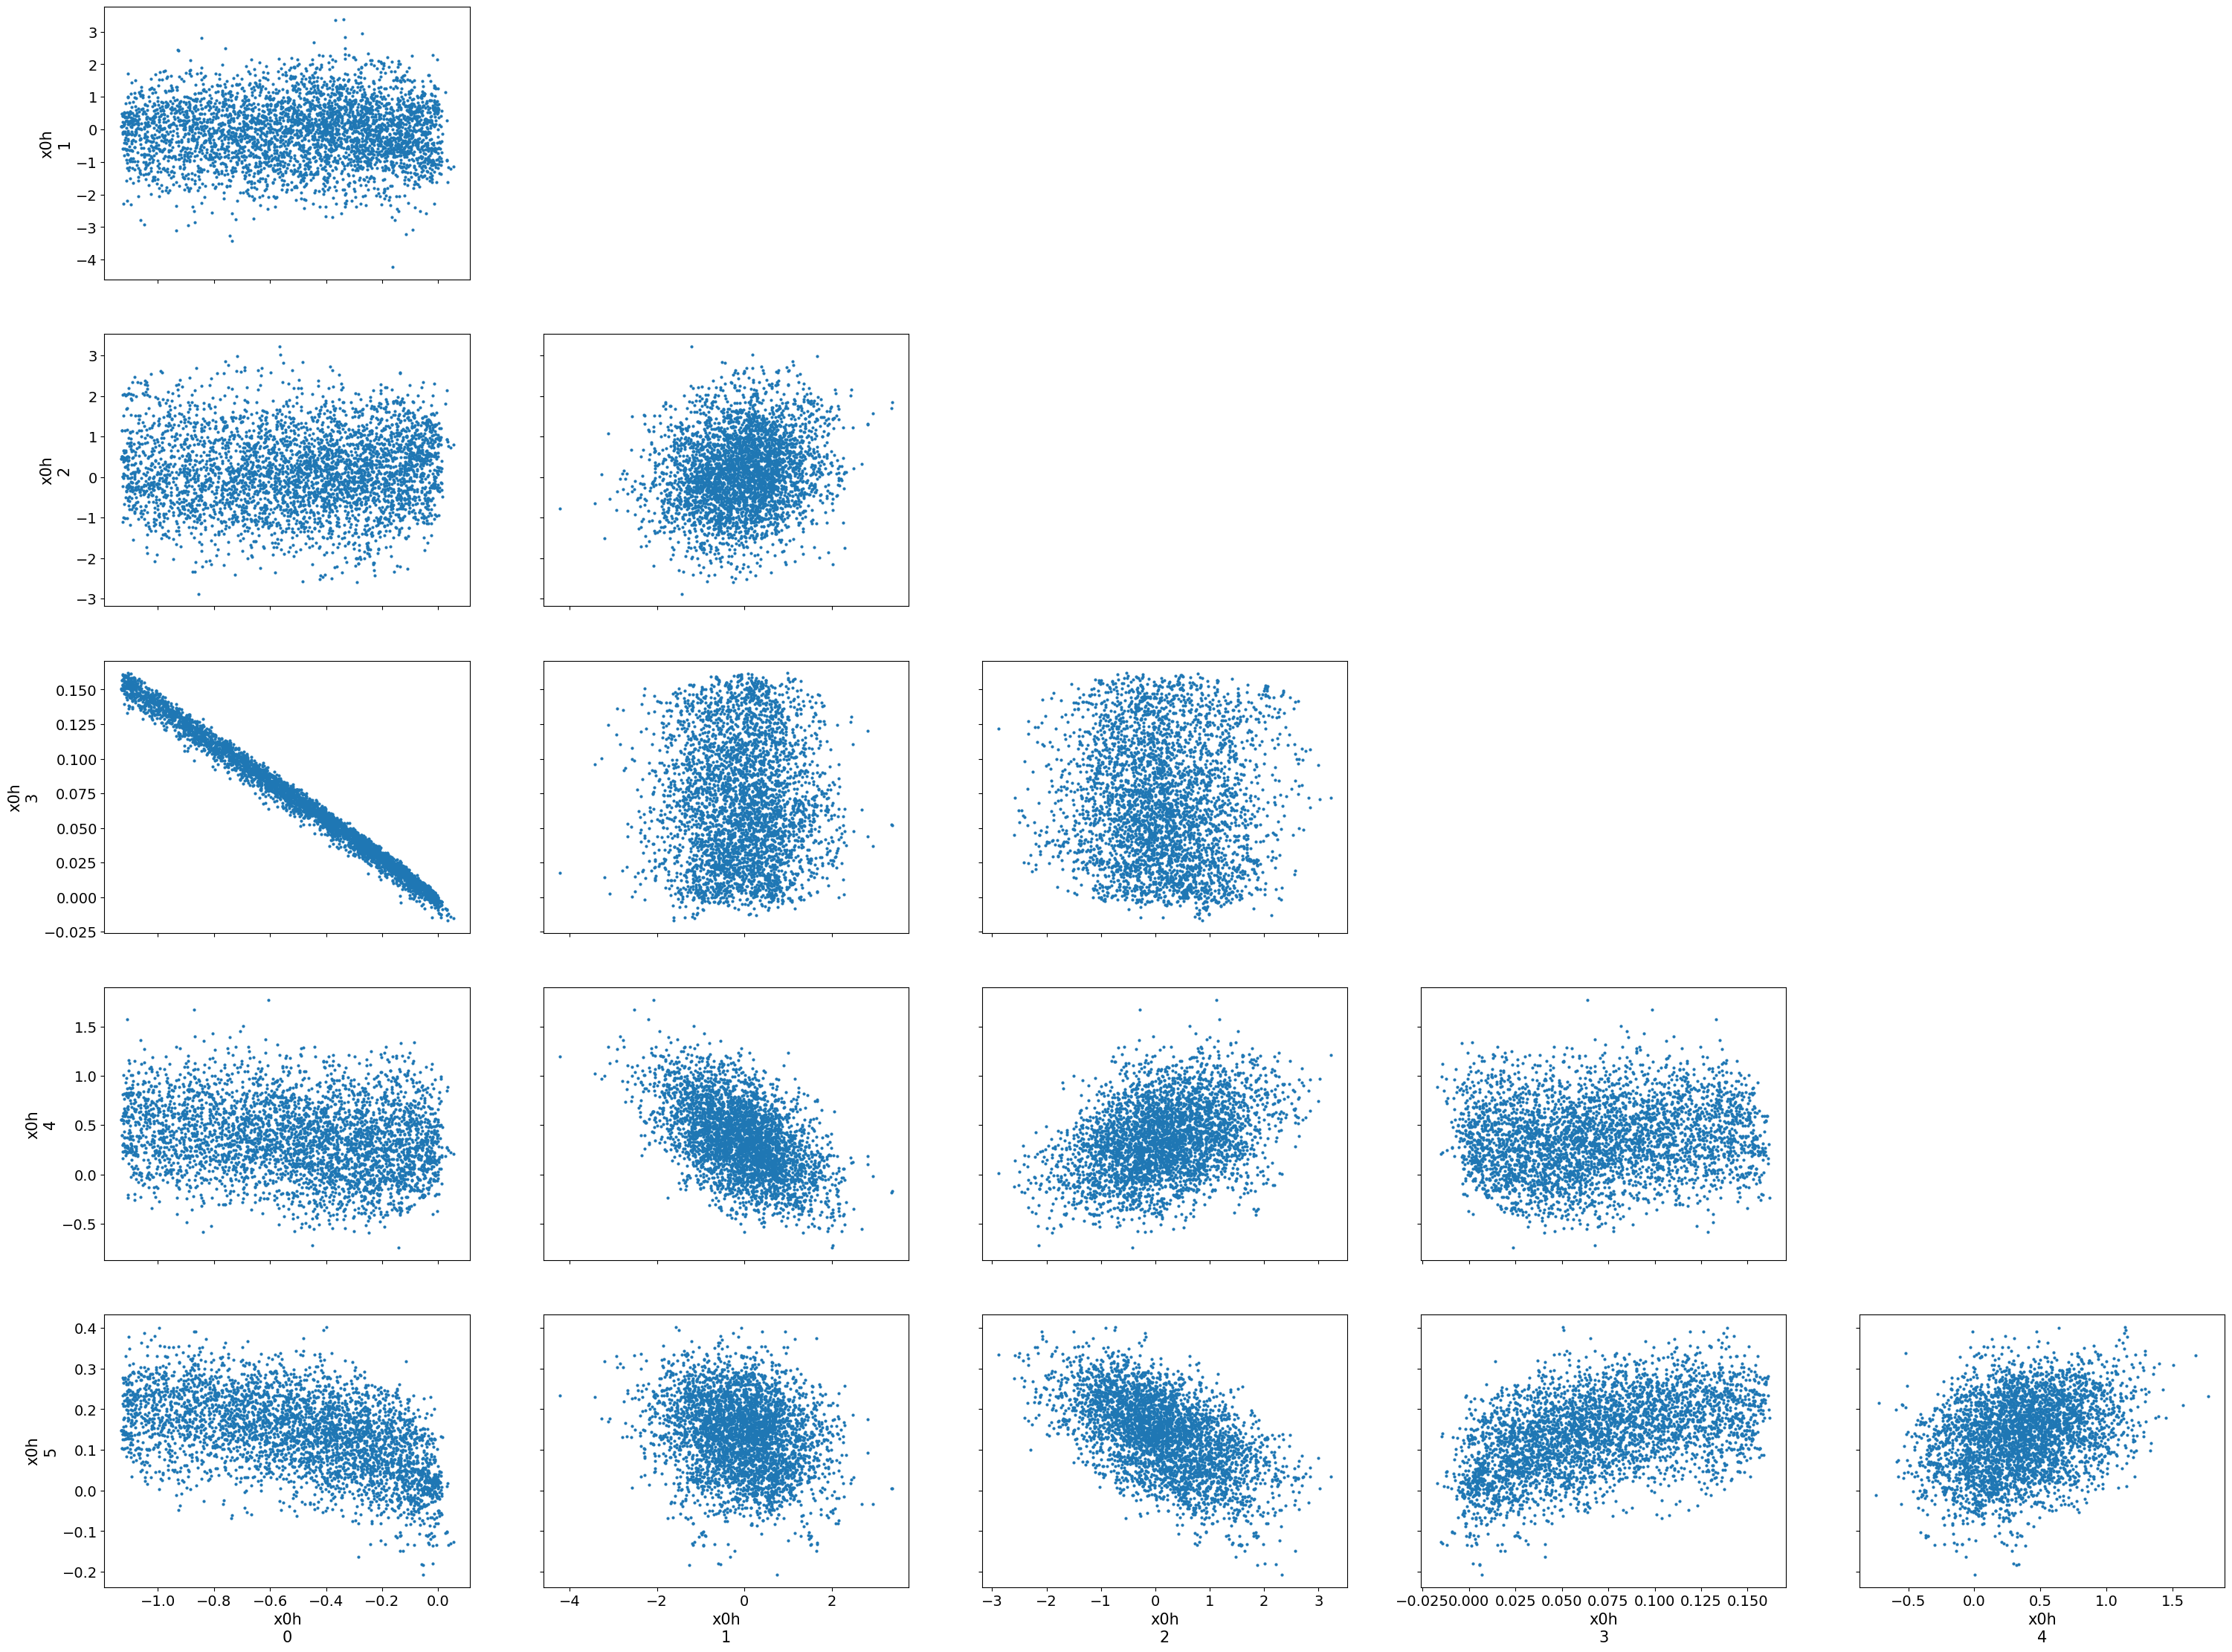

In [12]:
az.plot_pair(inf_data);

## MCMC all parameters

How about inferring all those JR parameters?

In [13]:
nfjax.jr_default_theta

JRTheta(A=3.25, B=22.0, a=0.1, b=0.05, v0=5.52, nu_max=0.0025, r=0.56, J=135.0, a_1=1.0, a_2=0.8, a_3=0.25, a_4=0.25, mu=0.22, I=0.0)

we can automate writing the code a bit,

In [24]:
for f in nfjax.JRTheta._fields:
    val = getattr(nfjax.jr_default_theta, f)
    half = val / 2
    print(f"{f}h = sample('{f}h', N({val}, {half}))")
    
parts = ', '.join([f'{f}h' for f in nfjax.JRTheta._fields])
print(f'ph = nfjax.JRTheta({parts})')

Ah = sample('Ah', N(3.25, 1.625))
Bh = sample('Bh', N(22.0, 11.0))
ah = sample('ah', N(0.1, 0.05))
bh = sample('bh', N(0.05, 0.025))
v0h = sample('v0h', N(5.52, 2.76))
nu_maxh = sample('nu_maxh', N(0.0025, 0.00125))
rh = sample('rh', N(0.56, 0.28))
Jh = sample('Jh', N(135.0, 67.5))
a_1h = sample('a_1h', N(1.0, 0.5))
a_2h = sample('a_2h', N(0.8, 0.4))
a_3h = sample('a_3h', N(0.25, 0.125))
a_4h = sample('a_4h', N(0.25, 0.125))
muh = sample('muh', N(0.22, 0.11))
Ih = sample('Ih', N(0.0, 0.0))
ph = nfjax.JRTheta(Ah, Bh, ah, bh, v0h, nu_maxh, rh, Jh, a_1h, a_2h, a_3h, a_4h, muh, Ih)


then paste that into a new model function, correcting `I` which is just 0 (not currently used in the model),

In [25]:
def model(x=None):
    from numpyro import sample
    from numpyro.distributions import Normal as N
    
    Ah = sample('Ah', N(3.25, 1.625))
    Bh = sample('Bh', N(22.0, 11.0))
    ah = sample('ah', N(0.1, 0.05))
    bh = sample('bh', N(0.05, 0.025))
    v0h = sample('v0h', N(5.52, 2.76))
    nu_maxh = sample('nu_maxh', N(0.0025, 0.00125))
    rh = sample('rh', N(0.56, 0.28))
    Jh = sample('Jh', N(135.0, 67.5))
    a_1h = sample('a_1h', N(1.0, 0.5))
    a_2h = sample('a_2h', N(0.8, 0.4))
    a_3h = sample('a_3h', N(0.25, 0.125))
    a_4h = sample('a_4h', N(0.25, 0.125))
    muh = sample('muh', N(0.22, 0.11))
    Ih = 0.0
    ph = nfjax.JRTheta(Ah, Bh, ah, bh, v0h, nu_maxh, rh, Jh, a_1h, a_2h, a_3h, a_4h, muh, Ih)
    
    x0h = sample('x0h', N(np.zeros(6), 1))
    xh_mu = curve(x0h, ph)
    sample('xh', N(xh_mu, 1), obs=x)

run MCMC again, though because the problem is harder, add 3 improvements
- use dense metric
- 8 chains instead of 4
- more samples

In [36]:
nuts_kernel = numpyro.infer.NUTS(model, dense_mass=True)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=8, 
                          num_warmup=2000, num_samples=2000)
key = jax.random.PRNGKey(0)
mcmc.run(key, x=x)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [37]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ah,-0.922,2.693,-6.144,5.252,0.921,0.675,9.0,23.0,2.96
Bh,-8.426,20.434,-44.815,24.790,6.992,5.124,9.0,44.0,3.02
Jh,110.856,173.291,-121.531,452.530,59.787,43.837,9.0,20.0,3.51
a_1h,-0.058,0.785,-1.280,1.350,0.265,0.194,9.0,8.0,3.54
a_2h,0.612,0.440,0.019,1.296,0.130,0.094,13.0,107.0,1.65
a_3h,-0.057,0.561,-1.173,0.483,0.196,0.144,9.0,8.0,2.67
a_4h,0.250,1.015,-1.896,1.988,0.357,0.263,8.0,8.0,5.75
ah,0.190,0.153,0.028,0.387,0.054,0.040,9.0,21.0,4.86
bh,0.290,0.558,-0.001,1.734,0.197,0.145,8.0,23.0,4.51
muh,-0.063,0.747,-1.970,0.553,0.263,0.194,9.0,8.0,3.60


Diagnostics are bad

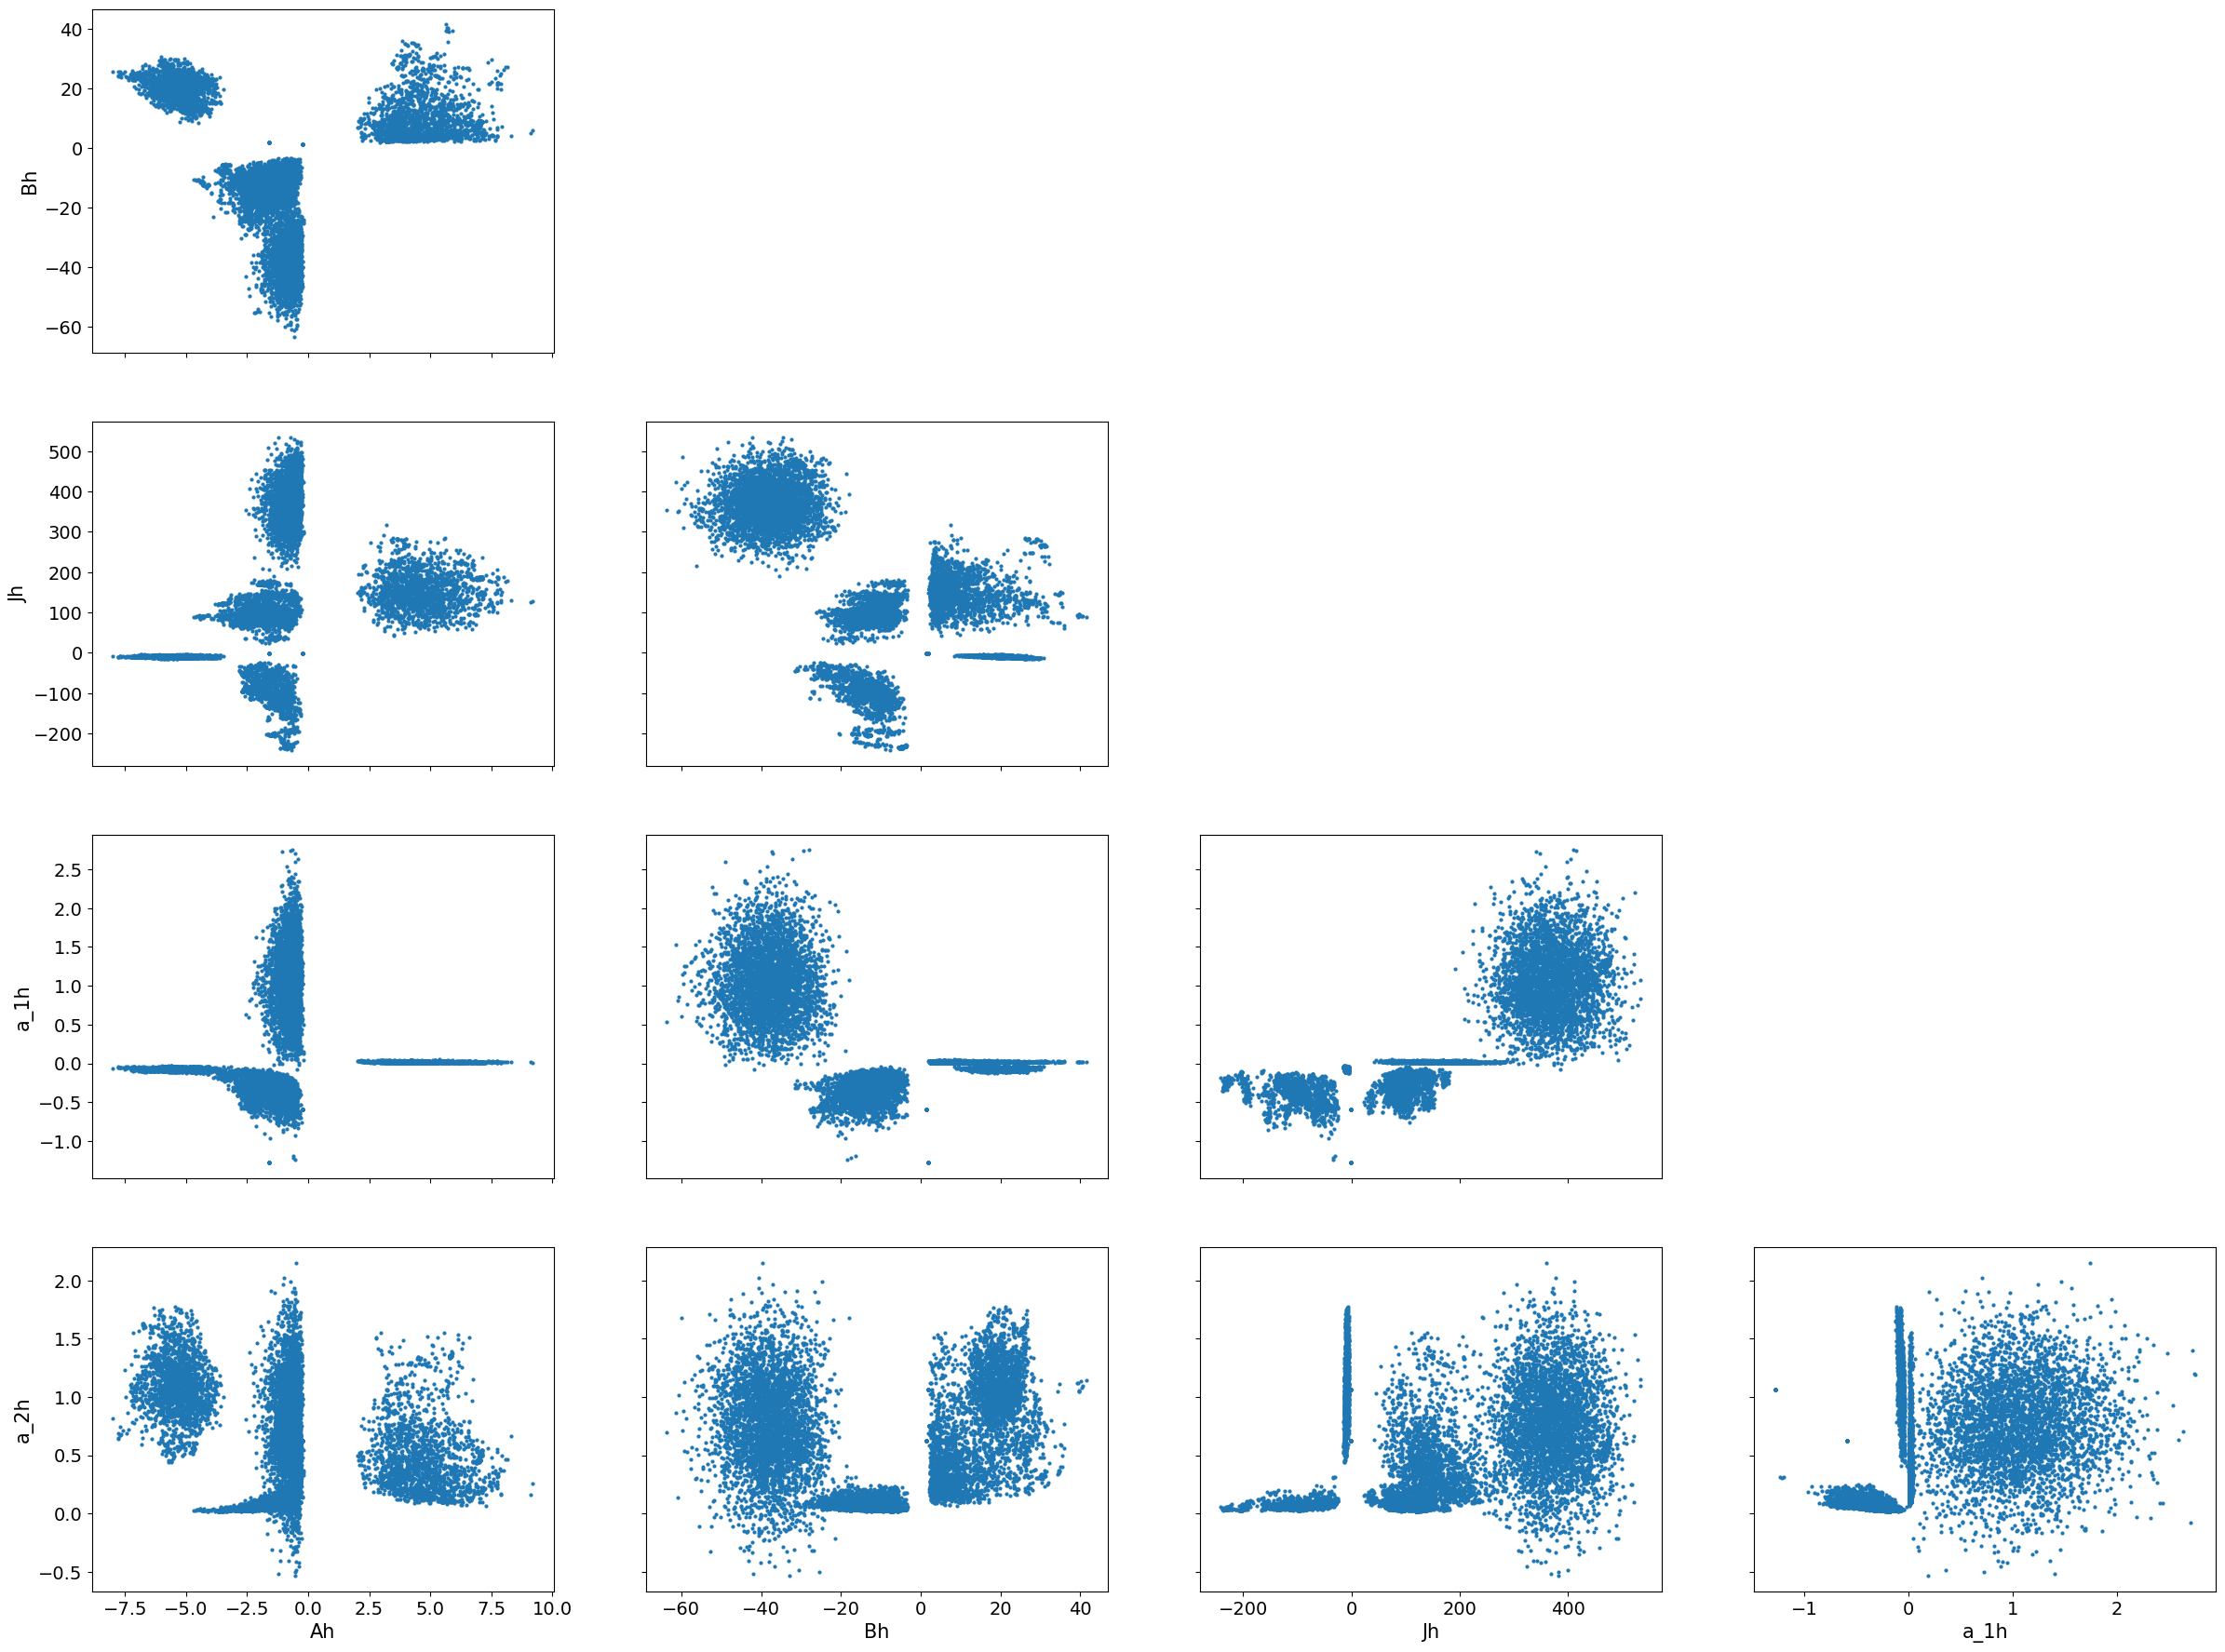

In [38]:
az.plot_pair(inf_data, var_names=['Ah', 'Bh', 'Jh', 'a_1h', 'a_2h']);

and pair plots suggest significant multimodality.

## Variational inference

We already can tell that the standard mean field VI won't work because the posterior is multimodal.  But autoregressive flow-based approximate densities should work, so let's try that before going on to Stein VI:

In [42]:
numpyro.infer.SVI?

In [57]:
svi = numpyro.infer.SVI(
    model,
    numpyro.infer.autoguide.AutoDiagonalNormal(model),
    numpyro.optim.Adam(step_size=1e-6),
    loss=numpyro.infer.Trace_ELBO()
)

svi.run(key, 10, x)

100%|█████████████████| 10/10 [00:01<00:00,  7.95it/s, init loss: 2725.1318, avg. loss [10-10]: nan]


SVIRunResult(params={'auto_loc': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan], dtype=float32), 'auto_scale': Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan], dtype=float32)}, state=SVIState(optim_state=(Array(10, dtype=int32, weak_type=True), OptimizerState(packed_state=([Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan], dtype=float32), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan], dtype=float32), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan], dtype=float32)], [Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan], dtype=float32), Array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, na

This requires more work, the autoguides (approximate densities) aren't working yet.

## Stein VI

Following the example at

https://num.pyro.ai/en/latest/examples/stein_bnn.html

In [39]:
from numpyro.contrib.einstein import RBFKernel, SteinVI

In [40]:
SteinVI(model,
       numpyro.infer.autoguide.AutoDelta,
       ...)